# Late Fusion by Ambiguity Groups (POST Features, Weighted Fusion)

This notebook splits trials into ambiguity groups and runs late fusion for each group.

In [9]:
import pickle
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load Pre-Extracted Features

In [10]:
# Load pre-extracted features
with open('../../data/results/features_POST/extracted_features_POST.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"\nAmbiguity distribution:")
print(merged_df['ambiguity'].value_counts().sort_index())


def weighted_late_fusion(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using logistic regression meta-learner.
    Returns subject-level accuracy for proper SEM calculation.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=42,
                                          class_weight='balanced')
                   for _ in X_modalities]
    
    # Store subject-level results
    subject_accs = {}  # subject_id -> accuracy
    subject_f1s = {}   # subject_id -> f1_score
    all_weights = []
    preds_all, y_true_all = [], []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        # Train base models and get probabilities
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Weighted fusion via logistic regression
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Calculate metrics for this subject (fold)
        test_subject = subjects[test_idx][0]  # All test samples are from same subject
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    # Convert subject-level results to arrays
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),  # Standard Error of the Mean
        'accuracy_std': np.std(subject_acc_values),      # Standard Deviation
        'accuracy_per_subject': subject_acc_values,      # Individual subject accuracies
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'f1_std': np.std(subject_f1_values),
        'f1_per_subject': subject_f1_values,
        'weights': norm_weights,
        'modality_names': modality_names,
        'n_subjects': len(subject_accs),
        'n_trials': len(y)
    }


✓ Loaded 12511 trials from 97 subjects
  Features extracted on: 2025-12-12 16:04:34

Ambiguity distribution:
ambiguity
0    4177
3    4162
6    4172
Name: count, dtype: int64


## 2. Create Ambiguity Groups

In [11]:
# Create ambiguity groups
merged_df['ambiguity_group'] = merged_df['ambiguity'].replace({0:'Low', 3:'Medium', 6:'High'})

print("\nAmbiguity group distribution:")
print(merged_df['ambiguity_group'].value_counts())


Ambiguity group distribution:
ambiguity_group
Low       4177
High      4172
Medium    4162
Name: count, dtype: int64


## 3. Run Late Fusion for Each Ambiguity Group

In [12]:
modality_names = ['Physiology (POST)', 'Behavior', 'Gaze']
group_results = {}

for group in ['Low', 'Medium', 'High']:
    print(f"\n{'='*80}")
    print(f"Ambiguity Group: {group}")
    print(f"{'='*80}")
    
    group_data = merged_df[merged_df['ambiguity_group'] == group]
    
    if len(group_data) < 20:
        print(f"Insufficient data ({len(group_data)} trials). Skipping.")
        continue
    
    # Check if we have enough subjects
    n_subjects = group_data['subject_id'].nunique()
    if n_subjects < 3:
        print(f"Insufficient subjects ({n_subjects}). Skipping.")
        continue
    
    print(f"Trials: {len(group_data)}")
    print(f"Subjects: {n_subjects}")
    print(f"Outcome distribution: {group_data['outcome'].value_counts().to_dict()}")
    
    # Show per-subject trial counts for this group
    subject_counts = group_data['subject_id'].value_counts().sort_index()
    print(f"Trials per subject: min={subject_counts.min()}, max={subject_counts.max()}, mean={subject_counts.mean():.1f}")
    
    X_physio = SimpleImputer(strategy='mean').fit_transform(group_data[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(group_data[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(group_data[gaze_cols])
    y = group_data['outcome'].values
    subjects = group_data['subject_id'].values
    
    X_modalities = [X_physio, X_behavior, X_gaze]
    
    results = weighted_late_fusion(X_modalities, y, subjects, modality_names)
    group_results[group] = results
    
    print(f"\nResults:")
    print(f"  Accuracy: {results['accuracy_mean']:.3f} ± {results['accuracy_sem']:.3f} (SEM) / ± {results['accuracy_std']:.3f} (SD)")
    print(f"  F1-Score: {results['f1_mean']:.3f} ± {results['f1_sem']:.3f} (SEM)")
    print(f"\n  Modality Weights:")
    for name, w in zip(modality_names, results['weights']):
        print(f"    {name}: {w:.3f}")


Ambiguity Group: Low
Trials: 4177
Subjects: 97
Outcome distribution: {1: 3401, 0: 776}
Trials per subject: min=4, max=82, mean=43.1

Results:
  Accuracy: 0.788 ± 0.020 (SEM) / ± 0.194 (SD)
  F1-Score: 0.741 ± 0.024 (SEM)

  Modality Weights:
    Physiology (POST): 0.490
    Behavior: 0.001
    Gaze: 0.509

Ambiguity Group: Medium
Trials: 4162
Subjects: 97
Outcome distribution: {1: 2859, 0: 1303}
Trials per subject: min=2, max=82, mean=42.9

Results:
  Accuracy: 0.644 ± 0.023 (SEM) / ± 0.224 (SD)
  F1-Score: 0.615 ± 0.025 (SEM)

  Modality Weights:
    Physiology (POST): 0.431
    Behavior: 0.011
    Gaze: 0.557

Ambiguity Group: High
Trials: 4172
Subjects: 97
Outcome distribution: {0: 2194, 1: 1978}
Trials per subject: min=3, max=84, mean=43.0

Results:
  Accuracy: 0.578 ± 0.016 (SEM) / ± 0.156 (SD)
  F1-Score: 0.575 ± 0.017 (SEM)

  Modality Weights:
    Physiology (POST): 0.279
    Behavior: 0.004
    Gaze: 0.717


## 4. Compare Results Across Groups

In [13]:
if len(group_results) > 0:
    comparison_df = pd.DataFrame([
        {
            'Group': group,
            'N_Trials': results['n_trials'],
            'N_Subjects': results['n_subjects'],
            'Accuracy': results['accuracy_mean'],
            'Accuracy_SEM': results['accuracy_sem'],
            'Accuracy_SD': results['accuracy_std'],
            'F1-Score': results['f1_mean'],
            'F1_SEM': results['f1_sem'],
            'Physiology_Weight': results['weights'][0],
            'Behavior_Weight': results['weights'][1],
            'Gaze_Weight': results['weights'][2]
        }
        for group, results in group_results.items()
    ])
    
    print("\n" + "="*80)
    print("COMPARISON ACROSS AMBIGUITY GROUPS (with SEM)")
    print("="*80)
    print(comparison_df[['Group', 'N_Trials', 'N_Subjects', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD']].to_string(index=False))
    
    print("\n" + "="*80)
    print("NOTE: Error bars use SEM (Standard Error of Mean) from subject-level accuracies")
    print("WARNING: Subjects are NOT equally represented in each group!")
    print("="*80)
else:
    print("No groups with sufficient data for comparison.")


COMPARISON ACROSS AMBIGUITY GROUPS (with SEM)
 Group  N_Trials  N_Subjects  Accuracy  Accuracy_SEM  Accuracy_SD
   Low      4177          97  0.788424      0.019837     0.194366
Medium      4162          97  0.644000      0.022855     0.223930
  High      4172          97  0.577924      0.015914     0.155923

NOTE: Error bars use SEM (Standard Error of Mean) from subject-level accuracies


## 5. Visualizations

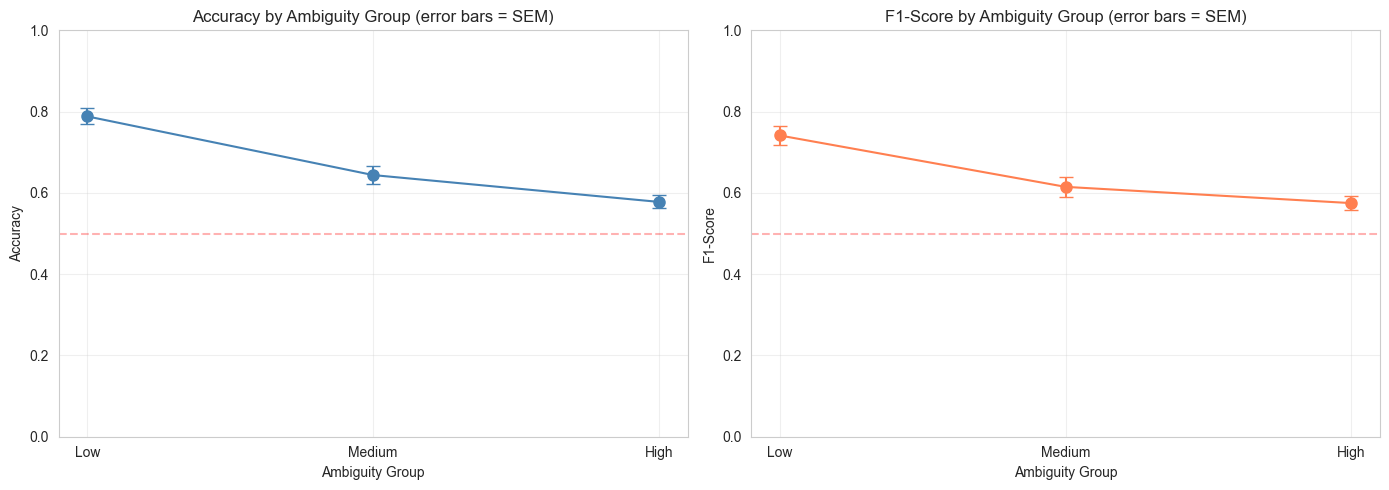

In [14]:
if len(group_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy with SEM error bars
    ax = axes[0]
    ax.errorbar(comparison_df['Group'], comparison_df['Accuracy'], 
                yerr=comparison_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue', markersize=8)
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Ambiguity Group (error bars = SEM)')
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    ax.grid(alpha=0.3)
    
    # F1-Score with SEM error bars
    ax = axes[1]
    ax.errorbar(comparison_df['Group'], comparison_df['F1-Score'], 
                yerr=comparison_df['F1_SEM'], fmt='o-', capsize=5, color='coral', markersize=8)
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('F1-Score')
    ax.set_title('F1-Score by Ambiguity Group (error bars = SEM)')
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

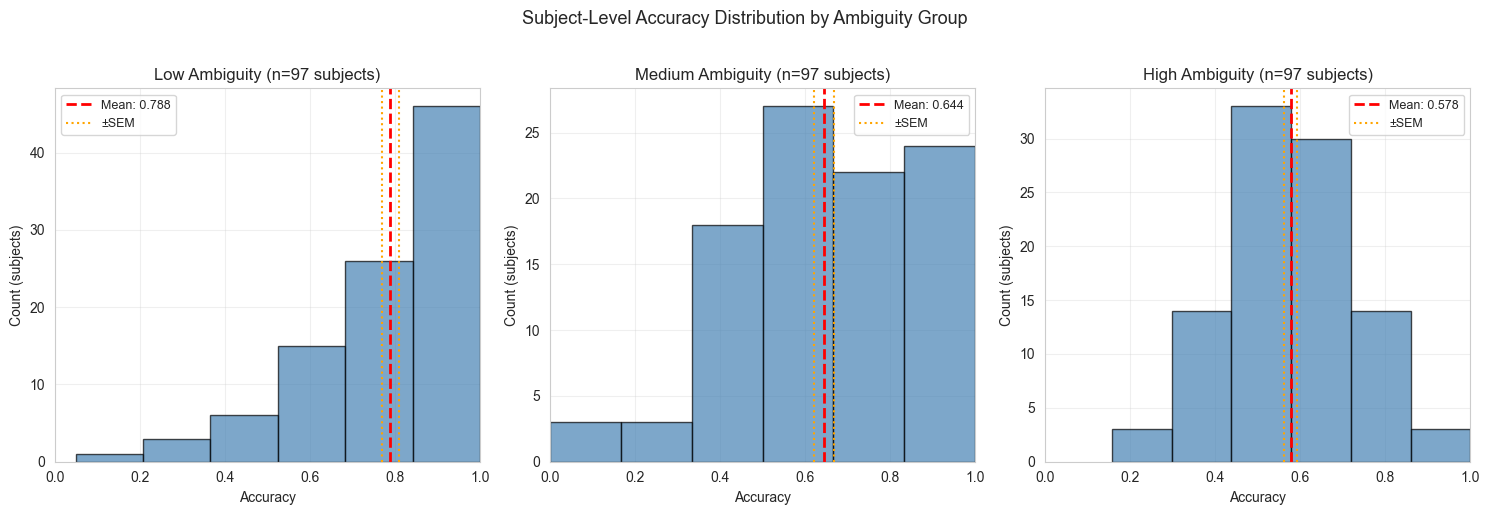

In [15]:
# Plot subject-level accuracy distributions for each ambiguity group
if len(group_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, (group, results) in enumerate(group_results.items()):
        ax = axes[idx]
        subject_accs = results['accuracy_per_subject']
        
        # Histogram
        ax.hist(subject_accs, bins=6, color='steelblue', alpha=0.7, edgecolor='black')
        ax.axvline(results['accuracy_mean'], color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {results['accuracy_mean']:.3f}")
        ax.axvline(results['accuracy_mean'] - results['accuracy_sem'], color='orange',
                   linestyle=':', linewidth=1.5, label=f"±SEM")
        ax.axvline(results['accuracy_mean'] + results['accuracy_sem'], color='orange',
                   linestyle=':', linewidth=1.5)
        
        ax.set_xlabel('Accuracy')
        ax.set_ylabel('Count (subjects)')
        ax.set_title(f'{group} Ambiguity (n={results["n_subjects"]} subjects)')
        ax.set_xlim([0, 1])
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.suptitle('Subject-Level Accuracy Distribution by Ambiguity Group', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

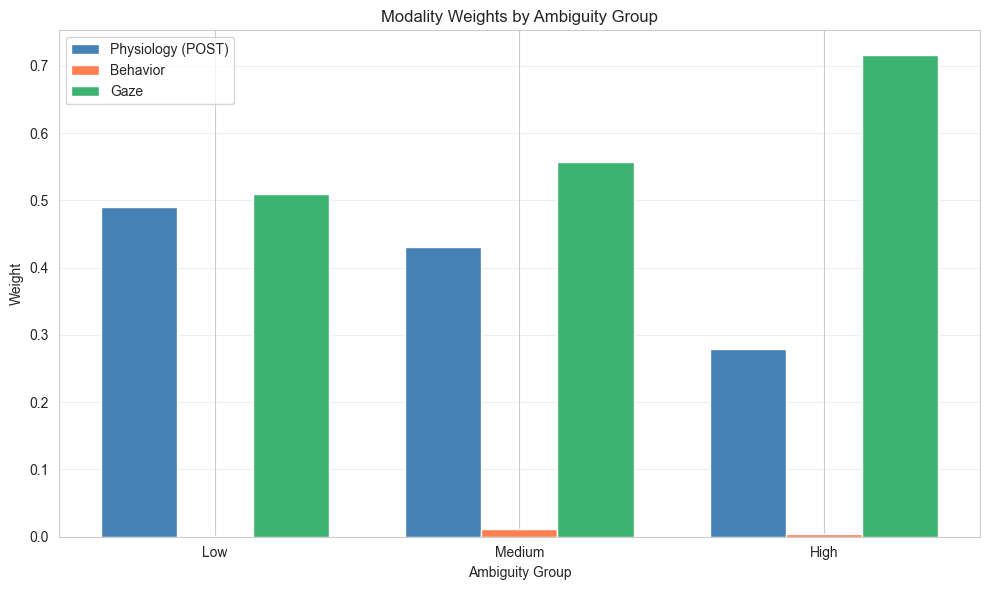

In [16]:
if len(group_results) > 0:
    # Modality weights by group
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.25
    
    ax.bar(x - width, comparison_df['Physiology_Weight'], width, 
           label='Physiology (POST)', color='steelblue')
    ax.bar(x, comparison_df['Behavior_Weight'], width, 
           label='Behavior', color='coral')
    ax.bar(x + width, comparison_df['Gaze_Weight'], width, 
           label='Gaze', color='mediumseagreen')
    
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('Weight')
    ax.set_title('Modality Weights by Ambiguity Group')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Group'])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## Save Results to CSV

Exporting all results for later analysis without re-running.

In [ ]:
import os
os.makedirs('../../data/results/fusion_model_results_POST', exist_ok=True)

# Save comparison results across groups
if 'comparison_df' in locals() and comparison_df is not None:
    output_file = '../../data/results/fusion_model_results_POST/ambiguity_group_late_fusion_POST_comparison.csv'
    comparison_df.to_csv(output_file, index=False)
    print(f"✓ Saved comparison results to: {output_file}")
    print(f"  Contains {len(comparison_df)} groups")

# Save detailed group results
if 'group_results' in locals() and group_results:
    for group_name, results in group_results.items():
        # Save modality weights
        weights_df = pd.DataFrame({
            'Modality': results.get('modality_names', ['Physiology', 'Behavior', 'Gaze']),
            'Weight': results.get('weights', [0, 0, 0])
        })
        weights_file = '../../data/results/fusion_model_results_POST/ambiguity_group_late_fusion_POST_{group_name}_weights.csv'
        weights_df.to_csv(weights_file, index=False)

        # Save subject-level accuracies if available
        if 'accuracy_per_subject' in results:
            subject_df = pd.DataFrame({
                'accuracy': results['accuracy_per_subject'],
                'f1_score': results.get('f1_per_subject', [])
            })
            subject_file = '../../data/results/fusion_model_results_POST/ambiguity_group_late_fusion_POST_{group_name}_subject_accuracies.csv'
            subject_df.to_csv(subject_file, index=False)

    print(f"✓ Saved detailed results for {len(group_results)} groups")

print(f"\nAll results saved to: ../../data/results/fusion_model_results_POST/")
